In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train = pd.read_csv('dataset/train_open.csv')

# map_label = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6}
# col = ['32']
# train[col] = train[col].applymap(map_label.get)

encoder = LabelEncoder()

data_X = train.loc[:, train.columns != '32']
data_y = encoder.fit_transform(train['32'])
data_y = np.array(data_y)

print(encoder.classes_)
print(data_y)

train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.3, random_state=1234)

['A' 'B' 'C' 'D' 'E' 'F']
[0 2 0 ... 3 2 0]


In [70]:
# Model Comparison
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC



In [80]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import cross_val_score

test = SelectKBest(score_func=chi2, k=train_X.shape[1])
fit = test.fit(train_X, train_y)

f_order = np.argsort(-fit.scores_) # sort index by decreasing order
sorted_columns = train.columns[f_order]

model = RandomForestClassifier()

for i in range(1, train_X.shape[1]+1):
    fs = sorted_columns[0:i]
    df_X_selected = train_X[fs]
    scores = cross_val_score(model, df_X_selected, train_y, cv=5)
    print(fs.tolist())
    print(np.round(scores.mean(), 4))



['20']
0.5714
['20', '8']
0.5968
['20', '8', '11']
0.6059
['20', '8', '11', '19']
0.6384
['20', '8', '11', '19', '13']
0.6598
['20', '8', '11', '19', '13', '29']
0.8097
['20', '8', '11', '19', '13', '29', '2']
0.8287
['20', '8', '11', '19', '13', '29', '2', '7']
0.8803
['20', '8', '11', '19', '13', '29', '2', '7', '14']
0.8822
['20', '8', '11', '19', '13', '29', '2', '7', '14', '16']
0.8882
['20', '8', '11', '19', '13', '29', '2', '7', '14', '16', '24']
0.8914
['20', '8', '11', '19', '13', '29', '2', '7', '14', '16', '24', '17']
0.8949
['20', '8', '11', '19', '13', '29', '2', '7', '14', '16', '24', '17', '4']
0.8906
['20', '8', '11', '19', '13', '29', '2', '7', '14', '16', '24', '17', '4', '5']
0.9005
['20', '8', '11', '19', '13', '29', '2', '7', '14', '16', '24', '17', '4', '5', '22']
0.8937
['20', '8', '11', '19', '13', '29', '2', '7', '14', '16', '24', '17', '4', '5', '22', '26']
0.8977
['20', '8', '11', '19', '13', '29', '2', '7', '14', '16', '24', '17', '4', '5', '22', '26', '10']

In [81]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


model = RandomForestClassifier()

sfs1 = SFS(model, k_features=17, verbose=0, scoring='accuracy', cv=5, n_jobs=-1)
sfs1 = sfs1.fit(train_X, train_y)

print(sfs1.k_feature_names_) # selected feature name

scores = cross_val_score(model, train_X[list(sfs1.k_feature_names_)], train_y, cv=5)
print("Acc: "+str(scores.mean()))

('1', '2', '4', '5', '6', '7', '8', '14', '15', '16', '19', '20', '24', '26', '29', '30', '31')
Acc: 0.8925483262611976


In [108]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import numpy as np
import pprint as pp

rf = RandomForestClassifier(random_state=1234)

max_depth = [int(x) for x in np.linspace(10, 110, num=10)]
max_depth.append(None)

rand_list = {
    'bootstrap': [True, False],
    'max_depth': max_depth,
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [int(x) for x in np.linspace(2, 20, num=1)],
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
}

random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=rand_list, cv=5, n_jobs=-1, verbose=2, scoring="accuracy")
random_search_rf.fit(train_X[list(sfs1.k_feature_names_)], train_y)
pp.pprint(random_search_rf.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'bootstrap': False,
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1600}


In [102]:
from sklearn.metrics import accuracy_score
import xgboost as xgb


D_train = xgb.DMatrix(train_X, label=train_y)
D_test = xgb.DMatrix(test_X, label=test_y)

random_list = {
    'booster': 'gbtree',
    'eta': 0.2,
    'max_depth' : 3,
    'objective': 'reg:squarederror',
    'eval_metric': 'error',
}
steps = 20

xg = xgb.train(random_list, D_train, steps)

random_search_xg = RandomizedSearchCV(estimator=xg, param_distributions=rand_list, cv=5, n_jobs=-1, verbose=2, scoring="accuracy")
random_search_xg.fit(train_X[list(sfs1.k_feature_names_)], train_y)
pp.pprint(random_search_xg.best_params_)
pp.pprint(random_search_xg.best_score_)

pred = model.predict(D_test)

round_preds = np.round(pred) # real -> [0,1]
accuracy_score(test_y, round_preds)

0.6857670979667283

In [84]:
from scipy import stats

svc = SVC(probability = True, random_state = 1)

rand_list = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.1, 1)}
              
random_search_svc = RandomizedSearchCV(estimator=svc, param_distributions = rand_list, n_iter = 20, n_jobs = -1, cv = 5, random_state = 2017, scoring = "accuracy", verbose=2) 
random_search_svc.fit(train_X[list(sfs1.k_feature_names_)], train_y) 
pp.pprint(random_search_svc.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'C': 2.209602254061174, 'gamma': 0.8670701646824878}


In [86]:
knn = KNeighborsClassifier()

rand_list = {
    "leaf_size" : [int(x) for x in range(1,50)],
    "n_neighbors" : [int(x) for x in range(1,30)],
    "p" : [1,2],
}

random_search_knn = RandomizedSearchCV(estimator=knn, param_distributions=rand_list, n_jobs = -1, cv = 5, verbose=2)
random_search_knn.fit(train_X[list(sfs1.k_feature_names_)], train_y) 
pp.pprint(random_search_knn.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'leaf_size': 12, 'n_neighbors': 7, 'p': 1}


In [88]:
from sklearn.preprocessing import StandardScaler

dt = DecisionTreeClassifier()

max_depth = [int(x) for x in np.linspace(10, 110, num=10)]
max_depth.append(None)

rand_list = {
    'max_depth': max_depth,
    'min_samples_leaf': [int(x) for x in range(1, 5)],
    'min_samples_split': [int(x) for x in range(2, 11)],
    'criterion' : ['gini', 'entropy'],
}

random_search_dt = RandomizedSearchCV(estimator=dt, param_distributions=rand_list, n_jobs = -1, cv = 5, verbose=2, random_state=1234)
random_search_dt.fit(train_X[list(sfs1.k_feature_names_)], train_y) 
pp.pprint(random_search_dt.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2}


In [89]:
from scipy.stats import loguniform

lr = LogisticRegression()

rand_list = {
    "solver" : ['newton-cg', 'lbfgs', 'liblinear'],
    "penalty" : ['none', 'l1', 'l2', 'elasticnet'],
    "C" : loguniform(1e-5, 100)
}

random_search_lr = RandomizedSearchCV(estimator=lr, param_distributions=rand_list, n_jobs = -1, cv = 5, verbose=2, random_state=1234)
random_search_lr.fit(train_X[list(sfs1.k_feature_names_)], train_y) 
pp.pprint(random_search_lr.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\NBH\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\NBH\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\NBH\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\NBH\AppData\Local\Programs\Python\Python

{'C': 0.0031968399196034697, 'penalty': 'none', 'solver': 'newton-cg'}


c:\Users\NBH\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


  LR: 0.845733 (0.022157)
 KNN: 0.865988 (0.020667)
  DT: 0.835182 (0.020455)
  RF: 0.899555 (0.021576)
 SVM: 0.231393 (0.024351)


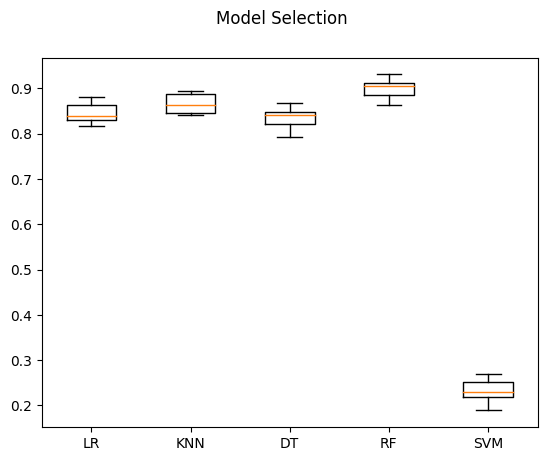

In [91]:
import matplotlib.pyplot as plt

models = []
models.append(('LR', random_search_lr.best_estimator_))
models.append(('KNN', random_search_knn.best_estimator_))
models.append(('DT', random_search_dt.best_estimator_))
models.append(('RF', random_search_rf.best_estimator_))
models.append(('SVM', random_search_svc.best_estimator_))

# Model Selection by Accuracy
seed = 7
results = []
names = []
scoring = 'accuracy'
for name, model in models:

    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, data_X[list(sfs1.k_feature_names_)], data_y, cv=kfold, scoring=scoring, n_jobs=-1)

    results.append(cv_results)
    names.append(name)
    msg = "%4s: %8f (%8f)" % (name, cv_results.mean(), cv_results.std())

    print(msg)

fig = plt.figure()
fig.suptitle('Model Selection')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [110]:
rf = RandomForestClassifier(random_state=1234)

max_depth = [int(x) for x in np.linspace(10, 110, num=10)]
max_depth.append(None)

grid_list = {
    'bootstrap': [True, False],
    'max_depth': max_depth,
    'min_samples_leaf': [int(x) for x in np.linspace(1, 10, num=1)],
    'min_samples_split': [int(x) for x in np.linspace(2, 20, num=1)],
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=20)]
}

random_search_rf = GridSearchCV(estimator=rf, param_grid=rand_list, cv=5, n_jobs=-1, verbose=2, scoring="accuracy")
random_search_rf.fit(train_X[list(sfs1.k_feature_names_)], train_y)
pp.pprint(random_search_rf.best_params_)
pp.pprint(random_search_rf.best_score_)


Fitting 5 folds for each of 660 candidates, totalling 3300 fits
{'bootstrap': False,
 'max_depth': 21,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1600}
0.8980991670595632


In [112]:
test = pd.read_csv('dataset/test_open.csv')

print(test)

# best model
best_random_model = random_search_rf.best_estimator_
best_random_predict = best_random_model.predict(test[list(sfs1.k_feature_names_)])

# predict_str = []

pd.DataFrame(encoder.inverse_transform(best_random_predict)).to_csv('predict.csv')    


             1   2    3    4    5    6   7    8    9   10  ...   22   23  24  \
0     0.376623  68  111   84   80   75  74   87   75   86  ...   75   67  67   
1     0.525974  89  134  104  109  112  67   95  120  112  ...  112  109  63   
2     0.344156  76  171   74   74   88  50   46   86   78  ...   82   66  53   
3     0.376623  45   95   66   73   57  56   53   77   65  ...   62   68  59   
4     0.512987  76  151   89   93   49  53   71   82   90  ...   90   92  53   
...        ...  ..  ...  ...  ...  ...  ..  ...  ...  ...  ...  ...  ...  ..   
1539  0.415584  65  144   82   82  103  67   75  114   86  ...   82   94  72   
1540  0.428571  80  144   93   90   77  75   88   76   97  ...   97   96  78   
1541  0.551948  85  129  113  113  113  93  107   91  108  ...  108   74  90   
1542  0.402597  59  140   74   78  107  64   77  114   83  ...   79   55  64   
1543  0.448052  74  118   94   94  109  80   94   77   96  ...   91   54  76   

      25   26  27        28  29   30   